In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
df = pd.read_csv('gene_expression.csv')

In [3]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [16]:
knn_palette = sns.color_palette(['#FF5050', '#29757A'])
knn_palette

[(1.0, 0.3137254901960784, 0.3137254901960784),
 (0.1607843137254902, 0.4588235294117647, 0.47843137254901963)]

<AxesSubplot:xlabel='Gene One', ylabel='Gene Two'>

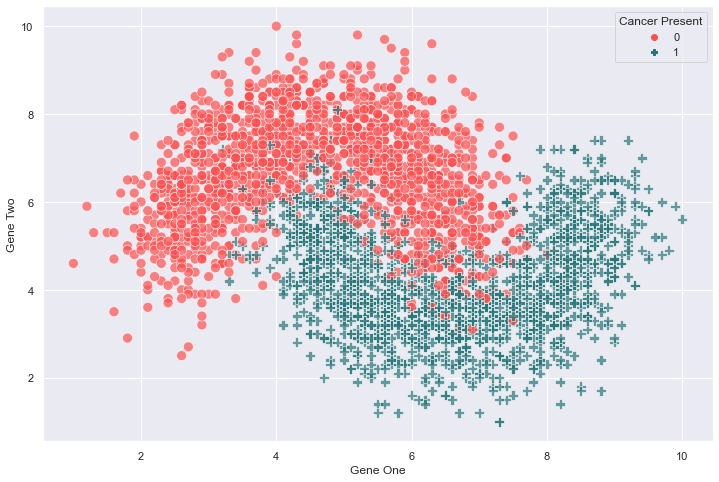

In [34]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Gene One',
                y='Gene Two', 
                hue='Cancer Present',
                data=df,
                alpha=0.7,
                palette= knn_palette,
                markers = ['o', 'P'],
                style = 'Cancer Present',
                s = 100)

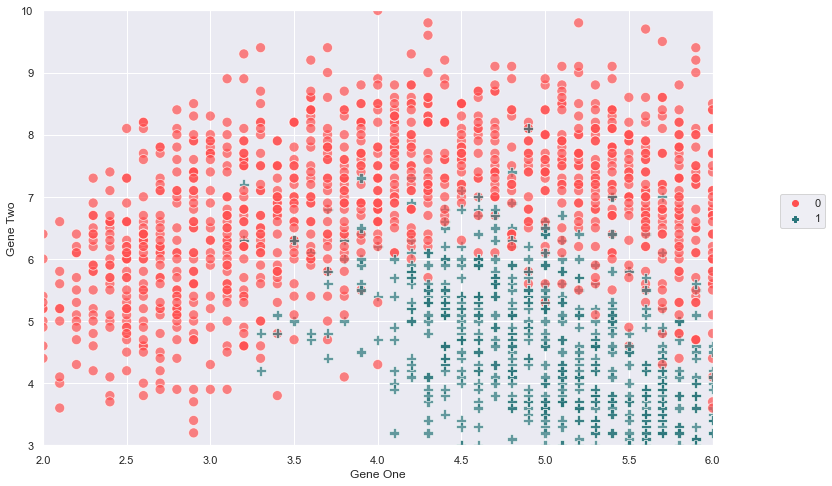

In [35]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Gene One',
                y='Gene Two', 
                hue='Cancer Present',
                data=df,
                alpha=0.7,
                palette= knn_palette,
                markers = ['o', 'P'],
                style = 'Cancer Present',
                s = 100)
plt.xlim(2,6)
plt.ylim(3,10)
plt.legend(loc=(1.1,0.5))

### Train|Test Split and Scaling Data

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
X = df.drop('Cancer Present', axis=1)
y = df['Cancer Present']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 42)

In [14]:
scaler = StandardScaler()

In [15]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test =  scaler.transform(X_test)

### Fit KNN algorithm

In [21]:
from sklearn.neighbors import KNeighborsClassifier

In [22]:
knn_model = KNeighborsClassifier(n_neighbors=1)

In [23]:
knn_model.fit(scaled_X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

### Model Evaluation

In [24]:
y_pred = knn_model.predict(scaled_X_test)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [26]:
accuracy_score(y_test, y_pred)

0.9011111111111111

<AxesSubplot:>

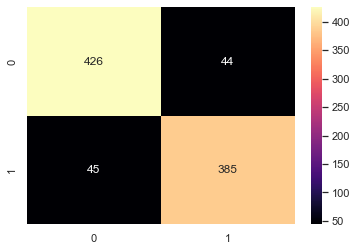

In [29]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True,cmap='magma',fmt='d')

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       470
           1       0.90      0.90      0.90       430

    accuracy                           0.90       900
   macro avg       0.90      0.90      0.90       900
weighted avg       0.90      0.90      0.90       900



## Elbow Method for Choosing Reasonable K Values

**NOTE: This uses the test set for the hyperparameter selection of K.**

In [32]:
test_error_rates = []

for k in range(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(scaled_X_train,y_train)
    
    y_pred_test = knn_model.predict(scaled_X_test)
    
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    test_error_rates.append(test_error)

Text(0.5, 0, 'K Value')

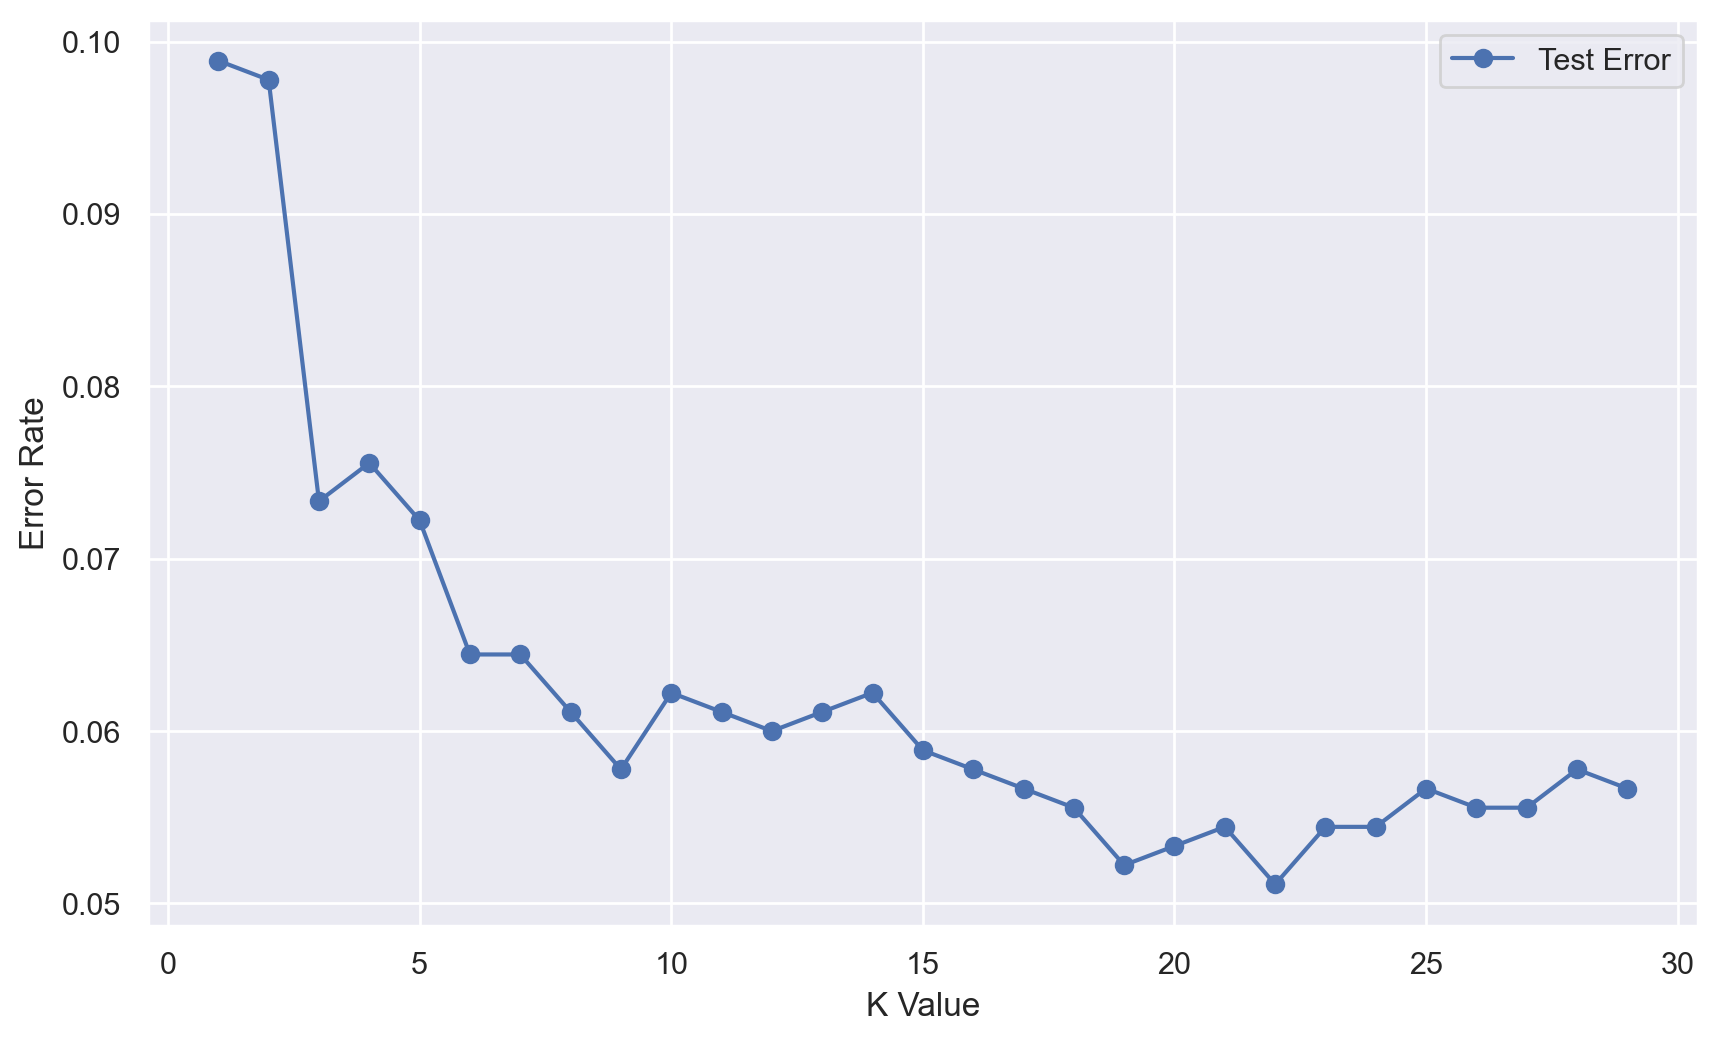

In [36]:
plt.figure(figsize=(10,6),dpi=200)

plt.plot(range(1,30), test_error_rates, label= 'Test Error', marker='o')
plt.legend()
plt.ylabel('Error Rate')
plt.xlabel('K Value')

### Full Cross Validation Grid Search for K Value

In [37]:
scaler =  StandardScaler()
knn = KNeighborsClassifier()

In [40]:
knn.get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [41]:
#string code   must matche variable name!

operations = [('scaler',scaler),('knn',knn)]

In [42]:
from sklearn.pipeline import Pipeline

In [48]:
pipe = Pipeline(operations)

In [44]:
from sklearn.model_selection import GridSearchCV

---
*Note: If your parameter grid is going inside a PipeLine, your parameter name needs to be specified in the following manner:**

* chosen_string_name + **two** underscores + parameter key name
* model_name + __ + parameter name
* knn_model + __ + n_neighbors
* knn_model__n_neighbors

The reason we have to do this is because it let's scikit-learn know what operation in the pipeline these parameters are related to (otherwise it might think n_neighbors was a parameter in the scaler).


In [45]:
k_values = list(range(1,20))

In [46]:
k_values

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [47]:
param_grid = {'knn__n_neighbors': k_values}

In [49]:
full_cv_classifier = GridSearchCV(pipe,param_grid,cv=5,scoring='accuracy')

In [50]:
# Use full X and y if you DON'T want a hold-out test set
# Use X_train and y_train if you DO want a holdout test set (X_test,y_test)
full_cv_classifier.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19]},
             scoring='accuracy')

In [51]:
full_cv_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=16))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=16),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 16,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [52]:
len(k_values)

19

In [53]:
full_cv_classifier.cv_results_['mean_test_score']

array([0.90380952, 0.90714286, 0.92142857, 0.91380952, 0.92380952,
       0.92047619, 0.92761905, 0.9252381 , 0.9247619 , 0.92285714,
       0.9252381 , 0.92428571, 0.92761905, 0.92809524, 0.92857143,
       0.93      , 0.92904762, 0.92857143, 0.92761905])

In [54]:
len(full_cv_classifier.cv_results_['mean_test_score'])

19

### Final Model

In [63]:
scaler = StandardScaler()
knn16 = KNeighborsClassifier(n_neighbors=16)
operations = [('scaler',scaler),('knn16',knn16)]

In [64]:
pipe = Pipeline(operations)

In [65]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn16', KNeighborsClassifier(n_neighbors=16))])

In [66]:
pipe_pred = pipe.predict(X_test)

In [67]:
print(classification_report(y_test, pipe_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       470
           1       0.95      0.93      0.94       430

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



<AxesSubplot:>

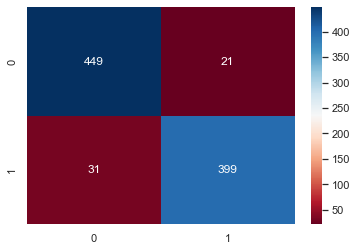

In [69]:
cm = confusion_matrix(y_test,pipe_pred)
sns.heatmap(cm,annot=True, cmap='RdBu',fmt='d')

### Testing Sample

In [70]:
single_sample = X_test.iloc[40]

In [71]:
single_sample

Gene One    3.8
Gene Two    6.3
Name: 194, dtype: float64

In [72]:
pipe.predict(single_sample.values.reshape(1,-1))

C:\Users\Oluwasegun\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [73]:
pipe.predict_proba(single_sample.values.reshape(1,-1))

C:\Users\Oluwasegun\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.9375, 0.0625]])